In [94]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [95]:
df_charging = pd.read_pickle("data/charging_modified.pkl")

# Get number of stations per site
stations_per_site = df_charging.groupby('siteID')['stationID'].nunique()

# Settings


In [96]:
# Time Interval
# start_date = "2018-09-04"
# end_date = "2018-09-06"
start_date = df_charging['connectionTime'].min().strftime('%Y-%m-%d')
end_date = df_charging['disconnectTime'].max().strftime('%Y-%m-%d')

start_date_time = pd.to_datetime(start_date)
end_date_time = pd.to_datetime(end_date) + pd.Timedelta('1 day') - pd.Timedelta('1 second')

### 1) Utilization Rates per Station

**We currently calculate this per minute as evs can be connected during an hour and be connected less than an hour. So breaking it down to an hour is a bit inaccurate, if you want fast computation for lage chunks replace the ('T') with ('H')**

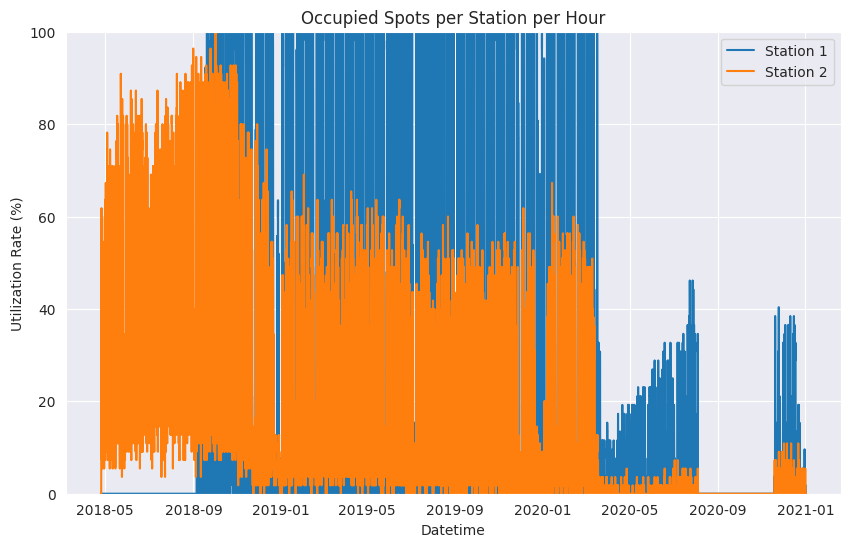

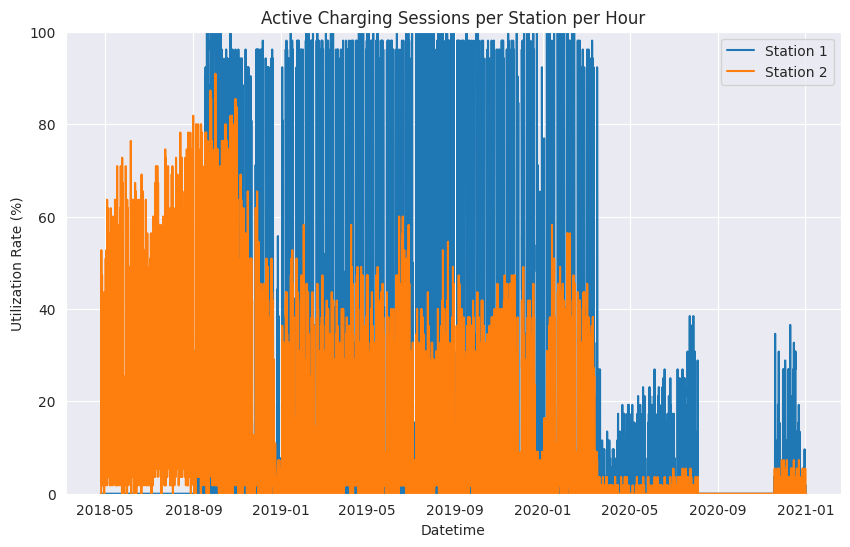

In [97]:

# Granularity of the utilization rate
granularity = 'H' # T is for minute, H is for hour

# Generate df with each row representing a minute in the time interval
df_time_interval = pd.date_range(start=start_date_time, end=end_date_time, freq=granularity)
df_time_interval = pd.DataFrame(df_time_interval, columns=['datetime'])
df_time_interval['datetime'] = pd.to_datetime(df_time_interval['datetime'], utc=True)

# Resample connectionTime and disconnectTime to full minutes, e.g., 10:31:20 -> 10:31:00
df_charging['connectionTime'] = df_charging['connectionTime'].dt.floor(granularity)
df_charging['disconnectTime'] = df_charging['disconnectTime'].dt.floor(granularity)

def count_sessions_total_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['disconnectTime'] >= point_in_time )]
    return filtered_df.shape[0]

def count_sessions_active_charging_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['disconnectTime'] >= point_in_time) & ((data['doneChargingTime'].isna()) | (data['doneChargingTime'] >= point_in_time))]
    return filtered_df.shape[0]

for site_id, data in df_charging.groupby('siteID'):
    df_time_interval[f'site{site_id}_total_count'] = df_time_interval['datetime'].apply(lambda datetime: count_sessions_total_at_point_in_time(data, datetime))
    df_time_interval[f'site{site_id}_charging_count'] = df_time_interval['datetime'].apply(lambda datetime: count_sessions_active_charging_at_point_in_time(data, datetime))

# Calculate the utilization rate for each station in minute
for site_id in stations_per_site.index:
    df_time_interval[f'site{site_id}_utilizationRate'] = (df_time_interval[f'site{site_id}_total_count'] / stations_per_site[site_id]) * 100
    df_time_interval[f'site{site_id}_utilizationRate_charging'] = (df_time_interval[f'site{site_id}_charging_count'] / stations_per_site[site_id]) * 100

df_time_interval = df_time_interval.set_index('datetime')
df_time_interval = df_time_interval.resample('H').mean()

def plot(df, title, y_column):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Datetime')
    plt.ylabel('Utilization Rate (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # Iterate over each station
    for site_id in stations_per_site.index:
        plt.plot(df.index, df[f'site{site_id}_{y_column}'], label=f'Station {site_id}')
    plt.legend()
    plt.show()

plot(df_time_interval, 'Occupied Spots per Station per Hour', 'utilizationRate')
plot(df_time_interval, 'Active Charging Sessions per Station per Hour', 'utilizationRate_charging')

# kWh Delivered per Station per Hour

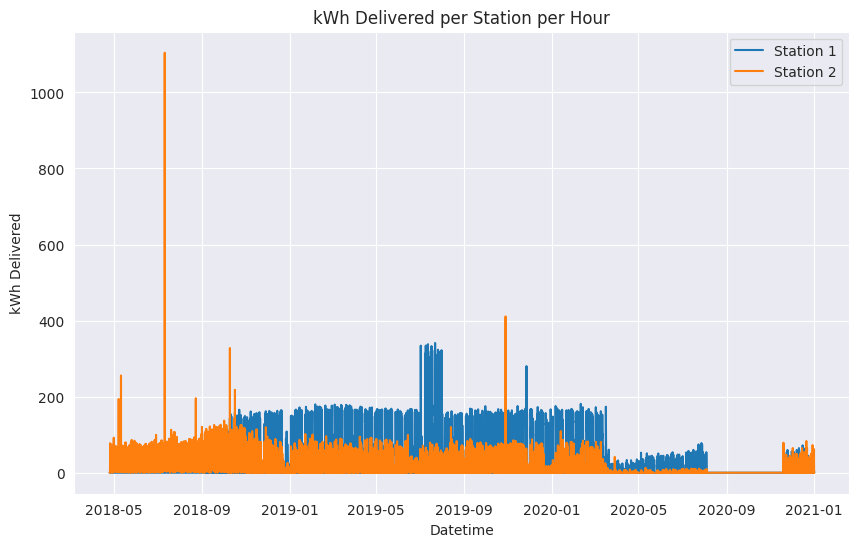

In [98]:
# Create time intervals
df_time_interval = pd.date_range(start=start_date_time, end=end_date_time, freq='H')
df_time_interval = pd.DataFrame(df_time_interval, columns=['datetime'])
df_time_interval['datetime'] = pd.to_datetime(df_time_interval['datetime'], utc=True)

# If doneChargingTime is NaN, the car is still charging, but here we can set it to the disconnectTime, as we are interested in the kWh delivered
df_charging['doneChargingTime'] = df_charging['doneChargingTime'].fillna(df_charging['disconnectTime'])

# Display charging sessions that are active at a given point in time
def count_kwh_delivered_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['doneChargingTime'] >= point_in_time)]
    return (filtered_df['kWhDelivered'] / filtered_df['ChargingTimeHours']).sum()

for site_id, data in df_charging.groupby('siteID'):
    df_time_interval[f'site{site_id}_kwhDelivered'] = df_time_interval['datetime'].apply(lambda datetime: count_kwh_delivered_at_point_in_time(data, datetime))

df_time_interval = df_time_interval.set_index('datetime')

plt.figure(figsize=(10, 6))
plt.title('kWh Delivered per Station per Hour')
plt.xlabel('Datetime')
plt.ylabel('kWh Delivered')
plt.grid(True)

# Iterate over each station
for site_id in stations_per_site.index:
    plt.plot(df_time_interval.index, df_time_interval[f'site{site_id}_kwhDelivered'], label=f'Station {site_id}')
plt.legend()
plt.show()